In [3]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from bart_single_node_responses import calculate_all_single_node_characteristics
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA

set_rc()

In [4]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

giverew_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'give_rew': True,
                            'fix_sizes': [0, s, 0]} for s in size]
fixprev_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'fix_prev_action_bug': True,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

giverew_evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=giverew_env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)
fixprev_evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=fixprev_env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [ ]:
r = pickle.load(open('data/meta_representation_results', 'rb'))

last_sizes = r['last_sizes']
unpopped_sizes = r['unpopped_sizes']
pop_rate = r['pop_rate']
rewards = r['rewards']
values = r['values']
action_probs = r['action_probs']
all_lens = r['all_lens']
all_num_balloons = r['all_num_balloons']

dec_flow_scores = r['dec_flow_scores']

iterators_idxs = r['iterators_idxs']
sizes = r['sizes']
ramp_f1s = r['ramp_f1s']
ramp_indiv_contribs = r['ramp_indiv_contribs']
confidence_scores = r['confidence_scores']
unconfidence_scores = r['unconfidence_scores']
unconfident_points = r['unconfident_points']
step_count = r['step_count']
all_decision_nodes = r['all_decision_nodes']

cluster_regressor_coefs = r['cluster_regressor_coefs']
cluster_regressor_scores = r['cluster_regressor_scores']
cluster_ks = r['cluster_ks']
pca_regressor_coefs = r['pca_regressor_coefs']
pca_regressor_scores = r['pca_regressor_scores']

In [8]:

give_rew = ['', 'giverew_', 'fixprev_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

iterators = [give_rew, postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

last_sizes = np.zeros(sizes + [17, 50])
unpopped_sizes = np.zeros(sizes + [17, 50])
pop_rate = np.zeros(sizes + [17])
rewards = np.zeros(sizes + [17, 2500])
values = np.zeros(sizes + [17, 2500])
action_probs = np.zeros(sizes + [17, 2500])
all_lens = np.zeros(sizes + [17])
all_num_balloons = np.zeros(sizes + [17])
balloon_steps = np.full(sizes + [17, 50], -1)
button_presses = np.full(sizes + [17, 100], -1)

# Decision flow
dec_flow_scores = np.zeros(sizes + [2]) # last axis: 0=decision nodes, 1=non-dec nodes

# Ramp to threshold F1 scores
ramp_f1s = np.zeros(sizes + [6, 11]) 
ramp_indiv_contribs = np.zeros(sizes + [6, 64])

# Confidence scores
confidence_scores = np.zeros(sizes)
unconfidence_scores = np.zeros(sizes)
unconfident_points = np.zeros(sizes)
step_count = np.zeros(sizes)
all_decision_nodes = np.zeros(sizes + [17, 64])

# Cluster and PCA regressor coefs
cluster_regressor_coefs = np.zeros(sizes + [6, 3, 64])
cluster_regressor_scores = np.zeros(sizes + [6, 3])
cluster_ks = np.zeros(sizes + [6])
pca_regressor_coefs = np.zeros(sizes + [6, 3, 6])
pca_regressor_scores = np.zeros(sizes + [6, 3])

In [9]:
r = pickle.load(open('data/meta_representation_results', 'rb'))

last_sizes[:2] = r['last_sizes'][:2]
unpopped_sizes[:2] = r['unpopped_sizes'][:2]
pop_rate[:2] = r['pop_rate'][:2]
rewards[:2] = r['rewards'][:2]
values[:2] = r['values'][:2]
action_probs[:2] = r['action_probs'][:2]
all_lens[:2] = r['all_lens'][:2]
all_num_balloons[:2] = r['all_num_balloons'][:2]

dec_flow_scores[:2] = r['dec_flow_scores'][:2]

iterators_idxs[:2] = r['iterators_idxs'][:2]
sizes[:2] = r['sizes'][:2]
ramp_f1s[:2] = r['ramp_f1s'][:2]
ramp_indiv_contribs[:2] = r['ramp_indiv_contribs'][:2]
confidence_scores[:2] = r['confidence_scores'][:2]
unconfidence_scores[:2] = r['unconfidence_scores'][:2]
unconfident_points[:2] = r['unconfident_points'][:2]
step_count[:2] = r['step_count'][:2]
all_decision_nodes[:2] = r['all_decision_nodes'][:2]

cluster_regressor_coefs[:2] = r['cluster_regressor_coefs'][:2]
cluster_regressor_scores[:2] = r['cluster_regressor_scores'][:2]
cluster_ks[:2] = r['cluster_ks'][:2]
pca_regressor_coefs[:2] = r['pca_regressor_coefs'][:2]
pca_regressor_scores[:2] = r['pca_regressor_scores'][:2]

In [10]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['', 'giverew_', 'fixprev_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

iterators = [give_rew, postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# # Performance
# last_sizes = np.zeros(sizes + [17, 50])
# unpopped_sizes = np.zeros(sizes + [17, 50])
# pop_rate = np.zeros(sizes + [17])
# rewards = np.zeros(sizes + [17, 2500])
# values = np.zeros(sizes + [17, 2500])
# action_probs = np.zeros(sizes + [17, 2500])
# all_lens = np.zeros(sizes + [17])
# all_num_balloons = np.zeros(sizes + [17])
balloon_steps = np.full(sizes + [17, 50], -1)
button_presses = np.full(sizes + [17, 100], -1)

# # Decision flow
# dec_flow_scores = np.zeros(sizes + [2]) # last axis: 0=decision nodes, 1=non-dec nodes

# # Ramp to threshold F1 scores
# ramp_f1s = np.zeros(sizes + [6, 11]) 
# ramp_indiv_contribs = np.zeros(sizes + [6, 64])

# # Confidence scores
# confidence_scores = np.zeros(sizes)
# unconfidence_scores = np.zeros(sizes)
# unconfident_points = np.zeros(sizes)
# step_count = np.zeros(sizes)
# all_decision_nodes = np.zeros(sizes + [17, 64])

# # Cluster and PCA regressor coefs
# cluster_regressor_coefs = np.zeros(sizes + [6, 3, 64])
# cluster_regressor_scores = np.zeros(sizes + [6, 3])
# cluster_ks = np.zeros(sizes + [6])
# pca_regressor_coefs = np.zeros(sizes + [6, 3, 6])
# pca_regressor_scores = np.zeros(sizes + [6, 3])

for h, i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    if step_count[h, i, j, k, l] != 0:
        continue
    
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h in [1, 2] and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    
    if h == 1:
        res = giverew_evalu(model, obs_rms)
    elif h == 2:
        res = fixprev_evalu(model, obs_rms)
    else:
        res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)

    # Performance
    lens = np.array([len(d) for d in res['dones']])
    num_balloons = np.array([len(d) for d in res['data']['balloon_step']])
    unpop_size = get_sizes(res, obs_rms, last_only=True)
    for ep in range(17):
        last_sizes[h, i, j, k, l, ep, :num_balloons[ep]] = res['data']['last_size'][ep]
        unpopped_sizes[h, i, j, k, l, ep, :num_balloons[ep]] = unpop_size[ep]
        pop_rate[h, i, j, k, l, ep] = np.sum(res['data']['popped'][ep]) / num_balloons[ep]
        values[h, i, j, k, l, ep, :lens[ep]] = res['values'][ep].reshape(-1)
        rewards[h, i, j, k, l, ep, :lens[ep]] = res['rewards'][ep]
        action_probs[h, i, j, k, l, ep, :lens[ep]] = res['action_probs'][ep][:, 1]
        
        presses = np.argwhere(res['actions'][ep].reshape(-1) == 1).reshape(-1)
        bsteps = res['data']['balloon_step'][ep]
        button_presses[h, i, j, k, l, ep, :len(presses)] = presses
        balloon_steps[h, i, j, k, l, ep, :len(bsteps)] = bsteps
        
    all_lens[h, i, j, k, l] = lens
    all_num_balloons[h, i, j, k, l] = num_balloons
    
    # Decision flow
    try:
        score, dec_nodes = score_decision_flow(res, model)
        dec_flow_scores[h, i, j, k, l] = score.mean(axis=0)
        all_decision_nodes[h, i, j, k, l] = dec_nodes
    except:
        pass
    
    # Confidence scores    
    non_presses = (np.vstack(res['actions']) == 0).reshape(-1)
    presses = (np.vstack(res['actions']) == 1).reshape(-1)
    aps = np.vstack(res['action_probs'])[:, 1]
    confidence_scores[h, i, j, k, l] = aps[presses].mean()
    unconfidence_scores[h, i, j, k, l] = aps[non_presses].mean()
    unconfident_points[h, i, j, k, l] = ((aps > 0.2) & (aps < 0.8)).sum() 
    step_count[h, i, j, k, l] = len(aps)
    
    # Ramp to threshold scores
    f1_scores, individual_scores = score_logistic_classifiers(res)
    ramp_f1s[h, i, j, k, l] = f1_scores
    ramp_indiv_contribs[h, i, j, k, l] = individual_scores
    
    # Cluster and PCA regressor scores
    layers = ['shared0', 'shared1', 'actor0', 'actor1', 'critic0', 'critic1']
    for z, layer in enumerate(layers):
        try:
            coefs, scores = compute_regressor_coefficients(res, by_clusters=True, layer=layer)
            n_clusters = coefs.shape[1]
            cluster_regressor_coefs[h, i, j, k, l, z, :, :n_clusters] = coefs
            cluster_regressor_scores[h, i, j, k, l, z] = scores
            cluster_ks[h, i, j, k, l, z] = n_clusters
        
            coefs, scores = compute_regressor_coefficients(res, by_clusters=False, layer=layer)
            pca_regressor_coefs[h, i, j, k, l, z] = coefs
            pca_regressor_scores[h, i, j, k, l, z] = scores
        except:
            pass
    
    
                
pickle.dump({
    'last_sizes': last_sizes, 
    'unpopped_sizes': unpopped_sizes, 
    'pop_rate': pop_rate, 
    'rewards': rewards, 
    'values': values, 
    'action_probs': action_probs,
    'all_lens': all_lens, 
    'all_num_balloons': all_num_balloons, 
    'balloon_steps': balloon_steps,
    'button_presses': button_presses,
    
    'dec_flow_scores': dec_flow_scores,
    
    'iterators_idxs': iterators_idxs,
    'sizes': sizes,
    'ramp_f1s': ramp_f1s,
    'ramp_indiv_contribs': ramp_indiv_contribs,
    'confidence_scores': confidence_scores,
    'unconfidence_scores': unconfidence_scores,
    'unconfident_points': unconfident_points,
    'step_count': step_count,
    'all_decision_nodes': all_decision_nodes,
    
    'cluster_regressor_coefs': cluster_regressor_coefs, 
    'cluster_regressor_scores': cluster_regressor_scores, 
    'cluster_ks': cluster_ks, 
    'pca_regressor_coefs': pca_regressor_coefs, 
    'pca_regressor_scores': pca_regressor_scores, 
}, open('data/meta_representation_results', 'wb'))

100%|██████████| 1440/1440 [18:48:36<00:00, 47.03s/it]       


# Collect activation data

Here we'll just collect data for the "first" checkpoints

In [2]:
def split_by_lens(targets, ep_lens):
    '''
    split stacked data by ep lens
    '''
    cur_idx = 0
    split_targets = []
    for i in range(len(ep_lens)):
        next_idx = cur_idx + ep_lens[i]
        done_targets = targets[cur_idx:next_idx]
        cur_idx = next_idx

        split_targets.append(done_targets)
    return split_targets

In [14]:
# Load existing data
res = pickle.load(open('data/meta_rnn_gradients', 'rb'))
cluster_activations = res['cluster_activations']
cluster_labels = res['cluster_labels']
cluster_orientations = res['cluster_orientations']
rnn_hx_influences = res['rnn_hx_influences']
val_grads = res['val_grads']
action_grads = res['action_grads']
all_rnn_hxs = res['all_rnn_hxs']
all_ep_lens = res['all_ep_lens']
all_obs = res['all_obs']

In [15]:
"""
Collect activation data by running selected first >275 score checkpoints
on evaluation suite (agent's own actions), collecting activities, node clusters,
and measuring their influence on value and policy outputs
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['', 'giverew_', 'fixprev_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(10, 243, 30)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
# cluster_activations = {}
# cluster_labels = {}
# cluster_orientations = {}
# rnn_hx_influences = {}
# val_grads = {}
# action_grads = {}
# all_rnn_hxs = {}
# all_ep_lens = {}
# all_obs = {}

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    idx = (h, i, j, k)
    if idx in cluster_activations:
        continue
    
    chk = used_chks[chks[h, i, j, k]]
        
    if h in [1, 2] and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        
    if h == 1:
        res = giverew_evalu(model, obs_rms)
    elif h == 2:
        res = fixprev_evalu(model, obs_rms)
    else:
        res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    
    activ = np.vstack(res['rnn_hxs'])
    obs = np.vstack(res['obs'])
    ep_lens = [len(d) for d in res['dones']]
    k, cluster_activ, labels, kmeans, orientation = \
        kmeans_oriented_activations(res, layer='rnn_hxs')

    all_rnn_hxs[idx] = activ
    all_obs[idx] = obs
    all_ep_lens[idx] = ep_lens
    cluster_activations[idx] = cluster_activ
    cluster_labels[idx] = labels
    cluster_orientations[idx] = orientation

    give = (h == 1)
    val_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='value', plot=False, give=give)
    action_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='action', plot=False, give=give)
    rnn_hx_influences[idx] = compute_rnn_hxs_influences(model, res)

    
    
                
pickle.dump({
    'cluster_activations': cluster_activations,
    'cluster_labels': cluster_labels,
    'cluster_orientations': cluster_orientations,
    'rnn_hx_influences': rnn_hx_influences,
    'val_grads': val_grads,
    'action_grads': action_grads,
    'all_rnn_hxs': all_rnn_hxs,
    'all_ep_lens': all_ep_lens,
    'all_obs': all_obs,
}, open('data/meta_rnn_gradients', 'wb'))

100%|██████████| 180/180 [13:50<00:00,  4.61s/it]


In [6]:
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))

rnn_hx_influences2 = {}
idxs = select_chks_by_dimension()
for idx in tqdm(idxs):
    model, obs_rms = metabart_model_load(idx)
    obs = ares['all_obs'][idx[:4]]
    lens = ares['all_ep_lens'][idx[:4]]
    rnn_hxs = ares['all_rnn_hxs'][idx[:4]]

    obs = split_by_lens(obs, lens)
    rnn_hxs = split_by_lens(rnn_hxs, lens)
    r = {'rnn_hxs': rnn_hxs,
        'obs': obs}
    infl = compute_rnn_hxs_influences(model, r, max_unroll=4, nsteps=300)
    rnn_hx_influences2[idx[:4]] = infl

ares['rnn_hx_influences2'] = rnn_hx_influences2

pickle.dump(ares, open('data/meta_rnn_gradients', 'wb'))

100%|██████████| 120/120 [33:54<00:00, 16.96s/it]


# Collect forced activation data for meta clustering

We use predetermined trajectories to collect comparable activation data across agents and use it to assign meta clusters. Then calculate how these clusters contribute to their corresponding agent's policy and values, average this across the assigned meta clusters 

In [16]:
balloon_limits, forced_actions = pickle.load(open('data/metabart_forced_lim_acts', 'rb'))
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]
give_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'give_rew': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]
fixprev_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'fix_prev_action_bug': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]

# Note, seed does not matter since we are fixing the exact sizes of each balloon that appears
force_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)
force_give_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=give_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)
force_fixprev_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=fixprev_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)

def force_evalu(model, obs_rms, give_rew=False, fixprev=False):
    if give_rew and fixprev:
        print('Warning: both give_rew and fixprev are set to True, but only give_rew will activate')
    if give_rew:
        res = force_give_evalu_(model, obs_rms)
    elif fixprev:
        res = force_fixprev_evalu_(model, obs_rms)
    else:
        res = force_evalu_(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    return res

In [17]:
# Load existing data
res = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))
cluster_activations = res['cluster_activations']
rnn_hx_influences = res['rnn_hx_influences']
val_grads = res['val_grads']
action_grads = res['action_grads']
all_rnn_hxs = res['all_rnn_hxs']

In [18]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['', 'giverew_', 'fixprev_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(10, 243, 30)

# precollected clusters
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
# cluster_activations = {}
# rnn_hx_influences = {}
# val_grads = {}
# action_grads = {}
# all_rnn_hxs = {}

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    idx = (h, i, j, k)
    if idx in cluster_activations:
        continue
    
    chk = used_chks[chks[h, i, j, k]]
        
    if h in [1, 2] and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        
    give = True if h == 1 else False
    fixprev = True if h == 2 else False
    res = force_evalu(model, obs_rms, give_rew=give, fixprev=fixprev)
    
    activ = np.vstack(res['rnn_hxs'])

    labels = ares['cluster_labels'][idx]
    orientation = ares['cluster_orientations'][idx]
    cluster_activ, _, _ = get_cluster_activations(res, 'rnn_hxs', labels, 
                                                  orientation=orientation)
    
    all_rnn_hxs[idx] = activ
    cluster_activations[idx] = cluster_activ
    val_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='value', plot=False, give=give)
    action_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='action', plot=False, give=give)
    rnn_hx_influences[idx] = compute_rnn_hxs_influences(model, res)

                
pickle.dump({
    'cluster_activations': cluster_activations,
    'rnn_hx_influences': rnn_hx_influences,
    'val_grads': val_grads,
    'action_grads': action_grads,
    'all_rnn_hxs': all_rnn_hxs,
}, open('data/meta_rnn_forced_gradients', 'wb'))

100%|██████████| 180/180 [09:19<00:00,  3.11s/it]


In [22]:
'''
Add run results data to forced activations
'''

forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

idx = (0, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r = force_evalu(model, obs_rms, give_rew=False)

idx = (1, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_give = force_evalu(model, obs_rms, give_rew=True)

idx = (2, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_fixprev = force_evalu(model, obs_rms, fixprev=True)

del r['activations']
del r['rnn_hxs']
del r['action_log_probs']
del r['action_probs']
del r_give['activations']
del r_give['rnn_hxs']
del r_give['action_log_probs']
del r_give['action_probs']
del r_fixprev['activations']
del r_fixprev['rnn_hxs']
del r_fixprev['action_log_probs']
del r_fixprev['action_probs']

forced_ares['fixprev_res'] = r_fixprev
forced_ares['give_res'] = r_give
forced_ares['res'] = r

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

Largest number of clusters: 7


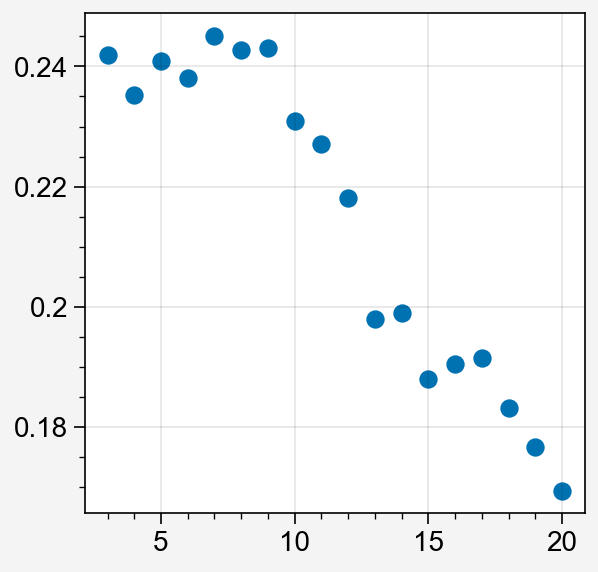

In [4]:
'''
Add meta clustering to the forced trajectory gradients, which is what we designed the
data set for
'''
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

# 1. Generate meta clusters and orient them for all of the clusters found
print('Largest number of clusters:', max([max(l) for l in ares['cluster_labels'].values()])+1)
all_idxs = list(forced_ares['cluster_activations'].keys())
activ = np.hstack(list(forced_ares['cluster_activations'].values()))
scaler = TimeSeriesScalerMeanVariance()
activ_normalized = scaler.fit_transform(activ.T[:, :, np.newaxis])  # Shape becomes [64, T, 1]
activ_normalized = activ_normalized.squeeze()  # Back to shape [64, T]
combactiv = np.vstack([activ_normalized, -activ_normalized])

max_k = 20  # Maximum number of clusters to try
silhouette_scores = []
ks = range(3, max_k + 1)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(combactiv)
    silhouette_avg = silhouette_score(combactiv, labels)
    silhouette_scores.append(silhouette_avg)

best_k = np.argmax(silhouette_scores) + 3
fig, ax = pplt.subplots()
ax.scatter(np.arange(3, 21), silhouette_scores)

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(combactiv)
orientation = []
labels = []
for i in range(activ.shape[1]):
    right_dist = np.linalg.norm(kmeans.cluster_centers_ - activ[:, i], axis=1)
    left_dist = np.linalg.norm(kmeans.cluster_centers_ + activ[:, i], axis=1)

    if right_dist.min() < left_dist.min():
        orientation.append(1)
        labels.append(np.argmin(right_dist))
    else:
        orientation.append(-1)
        labels.append(np.argmin(left_dist))

k = best_k
labels = np.array(labels)
orientation = np.array(orientation)
oriented_activ = (activ_normalized * orientation.reshape(-1, 1)).T

forced_ares['all_oriented_cactiv'] = oriented_activ

# 2. Calculate the distances from clusters to their meta cluster centers
cdists = []
for i in range(activ.shape[1]):
    a = activ[:, i]
    l = labels[i]
    c = kmeans.cluster_centers_[l]
    d = np.sqrt(np.sum((c - a)**2))
    cdists.append(d)
cdists = np.array(cdists)
clusters_per_agent = []
for idx in all_idxs:
    clusters_per_agent.append(forced_ares['cluster_activations'][idx].shape[1])

# 3. Add labels to each cluster for each agent based on their assigned meta cluster
# and add orientation information
per_agent_labels = {}
per_agent_orientations = {}
per_agent_cdists = {}
cur = 0
for i, n in enumerate(clusters_per_agent):
    idx = all_idxs[i]
    nxt = cur + n
    per_agent_labels[idx] = labels[cur:nxt]
    per_agent_orientations[idx] = orientation[cur:nxt]
    per_agent_cdists[idx] = cdists[cur:nxt]
    cur = nxt

forced_ares['per_agent_labels'] = per_agent_labels
forced_ares['per_agent_orientations'] = per_agent_orientations
forced_ares['per_agent_cdists'] = per_agent_cdists
forced_ares['labels'] = labels
forced_ares['orientations'] = orientation
forced_ares['kmeans'] = kmeans
forced_ares['cdists'] = cdists

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

In [7]:
'''
Compute contribution of each meta cluster to policy and value on average
and activation connectivity matrix
'''
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

# Can change the commented out weight lines to change whether we weight
#  each clusters contribution by how far it is to its meta cluster center
max_cdist = np.max(forced_ares['cdists'])

per_agent_action_grads = {}
per_agent_value_grads = {}

# 1. Calculate contribution of each cluster to its own agent's
#  policy and value, average these contributions for the whole meta cluster
all_cluster_val_grad = {}
for i in range(k):
    all_cluster_val_grad[i] = []

for idx in all_idxs:
    rnn_labels = ares['cluster_labels'][idx]
    rnn_val_grad = ares['val_grads'][idx]
    rnn_k = max(rnn_labels) + 1
    meta_cluster_labels = forced_ares['per_agent_labels'][idx]
    cdist = forced_ares['per_agent_cdists'][idx]
    # weight = (max_cdist - cdist) / max_cdist
    weight = 1
    cvalgrad = np.array([(rnn_val_grad[rnn_labels == i]).mean() for i in range(rnn_k)])
    cvalgrad = cvalgrad * weight
    for i, label in enumerate(meta_cluster_labels):
        all_cluster_val_grad[label].append(cvalgrad[i])
    per_agent_value_grads[idx] = cvalgrad.copy()
    
all_cluster_action_grad = {}
for i in range(k):
    all_cluster_action_grad[i] = []

for idx in all_idxs:
    try:
        rnn_labels = ares['cluster_labels'][idx]
        rnn_val_grad = ares['action_grads'][idx]
        rnn_k = max(rnn_labels) + 1
        meta_cluster_labels = forced_ares['per_agent_labels'][idx]
    except:
        continue
    cdist = forced_ares['per_agent_cdists'][idx]

    # weight = (max_cdist - cdist) / max_cdist
    weight = 1

    cvalgrad = np.array([(rnn_val_grad[rnn_labels == i]).mean() for i in range(rnn_k)])
    cvalgrad = cvalgrad * weight
    for i, label in enumerate(meta_cluster_labels):
        all_cluster_action_grad[label].append(cvalgrad[i])
    per_agent_action_grads[idx] = cvalgrad.copy()

# 2. Use t-test to determine which clusters have significant impact
#  on policy or value
val_grads = np.concatenate(list(all_cluster_val_grad.values()))
act_grads = np.concatenate(list(all_cluster_action_grad.values()))
val_scores = []
pol_scores = []
for i in range(k):
    t = ttest_ind(all_cluster_val_grad[i], val_grads)
    if t.statistic > 0:
        val_scores.append(1 - t.pvalue)
    else:
        val_scores.append(None)
    t = ttest_ind(all_cluster_action_grad[i], act_grads)
    if t.statistic > 0:
        pol_scores.append(1 - t.pvalue)
    else:
        pol_scores.append(None)

# 3. Calculate meta cluster influence connectivity
max_cdist = np.max(forced_ares['cdists'])
all_influences = np.zeros((k, k))
pair_counts = np.zeros((k, k))

for idx in all_idxs:
    influences = ares['rnn_hx_influences'][idx]
    labels = ares['cluster_labels'][idx]
    meta_labels = forced_ares['per_agent_labels'][idx]
    infl_table = get_cluster_influences(influences, labels)

    cdist = forced_ares['per_agent_cdists'][idx]
    # weight = (max_cdist - cdist) / max_cdist
    weight = 1
    
    for i in range(len(meta_labels)):
        for j in range(len(meta_labels)):
            meta_to = meta_labels[i]
            meta_from = meta_labels[j]
            # all_influences[meta_to, meta_from] += infl_table[i, j] * weight[i] * weight[j]
            all_influences[meta_to, meta_from] += infl_table[i, j] 
            pair_counts[meta_to, meta_from] += 1

cluster_influences = all_influences / pair_counts
        
forced_ares['per_agent_action_grads'] = per_agent_action_grads
forced_ares['per_agent_value_grads'] = per_agent_value_grads
forced_ares['meta_cluster_action_grads'] = all_cluster_action_grad
forced_ares['meta_cluster_value_grads'] = all_cluster_val_grad
forced_ares['meta_cluster_action_scores'] = pol_scores
forced_ares['meta_cluster_value_scores'] = val_scores
forced_ares['meta_cluster_influences'] = cluster_influences
forced_ares['all_value_grads'] = np.concatenate(list(forced_ares['per_agent_value_grads'].values()))
forced_ares['all_action_grads'] = np.concatenate(list(forced_ares['per_agent_action_grads'].values()))

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

# Individual node stimulus experiment

In [ ]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['', 'giverew_', 'fixprev_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
response_types = np.zeros(sizes + [64])
turning_points = np.zeros(sizes + [64])
lr_sens_bias = np.zeros(sizes + [64])
size_sensitivities = np.zeros(sizes + [6, 20, 64])
pop_sensitivities = np.zeros(sizes + [20, 64])
reversals = np.zeros(sizes + [64])

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    if h == 0:
        continue
    if h == 1:
        give = True
        fixprev = False
    elif h == 2:
        give = False
        fixprev = True
    else:
        give = False
        fixprev = False
    idx = (h, i, j, k)
    postfix = postfixes[i]
    model = models[j]
    t = k
    chkidx = select_chks([idx])[0]
    # print(idx, chkidx)
    model, obs_rms = metabart_model_load(chkidx)
    
    r = calculate_all_single_node_characteristics(model, obs_rms, give=give, fix_bug=fixprev,
                                                  recovery_diffs=True)
    response_types[idx] = r[0]
    turning_points[idx] = r[1]
    lr_sens_bias[idx] = r[2]
    size_sensitivities[idx] = r[3]
    pop_sensitivities[idx] = r[4]
    reversals[idx] = r[5]
    
pickle.dump({
    'response_types': response_types,
    'turning_points': turning_points,
    'lr_sens_bias': lr_sens_bias,
    'size_sensitivities': size_sensitivities,
    'pop_sensitivities': pop_sensitivities,
    'reversals': reversals,
}, open('data/meta_single_node_characteristics', 'wb'))